# Geospatial demand estimation

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]() & [Vignesh Shridharan](https://github.com/vignesh1987) <br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


### Import necessary modules

In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

%matplotlib inline

In [3]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.4f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters, spatialjoinvectors

### Define directories and dataset names

In [5]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"

In [6]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

# Part 1. Create base grid with H3

hexagons                                           geometry     lon  \
0  875526401ffffff  POLYGON ((27.48209 -11.05651, 27.47221 -11.066... 27.4693   
1  87399600affffff  POLYGON ((28.99674 -12.37961, 28.98671 -12.390... 28.9839   
2  87346dae4ffffff  POLYGON ((29.69690 -12.90119, 29.68681 -12.911... 29.6840   
3  875532d35ffffff  POLYGON ((27.00706 -14.43212, 26.99684 -14.442... 26.9943   
4  873468858ffffff  POLYGON ((29.63483 -14.29030, 29.62459 -14.300... 29.6219   

       lat  
0 -11.0524  
1 -12.3752  
2 -12.8967  
3 -14.4275  
4 -14.2855

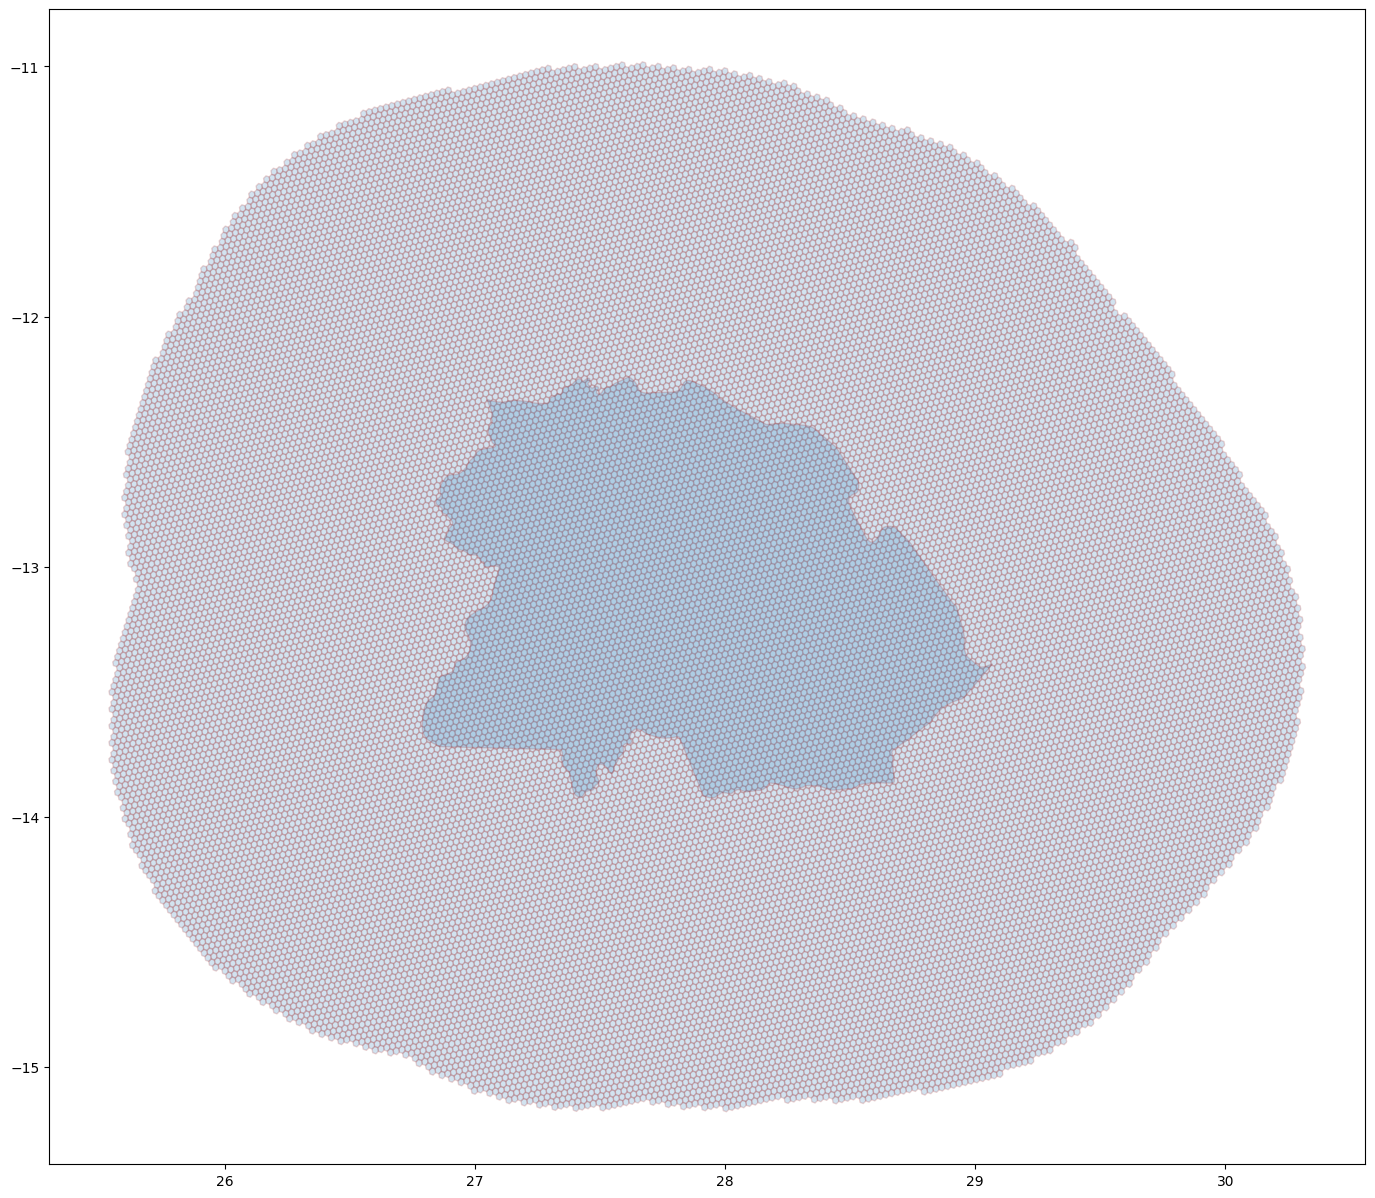

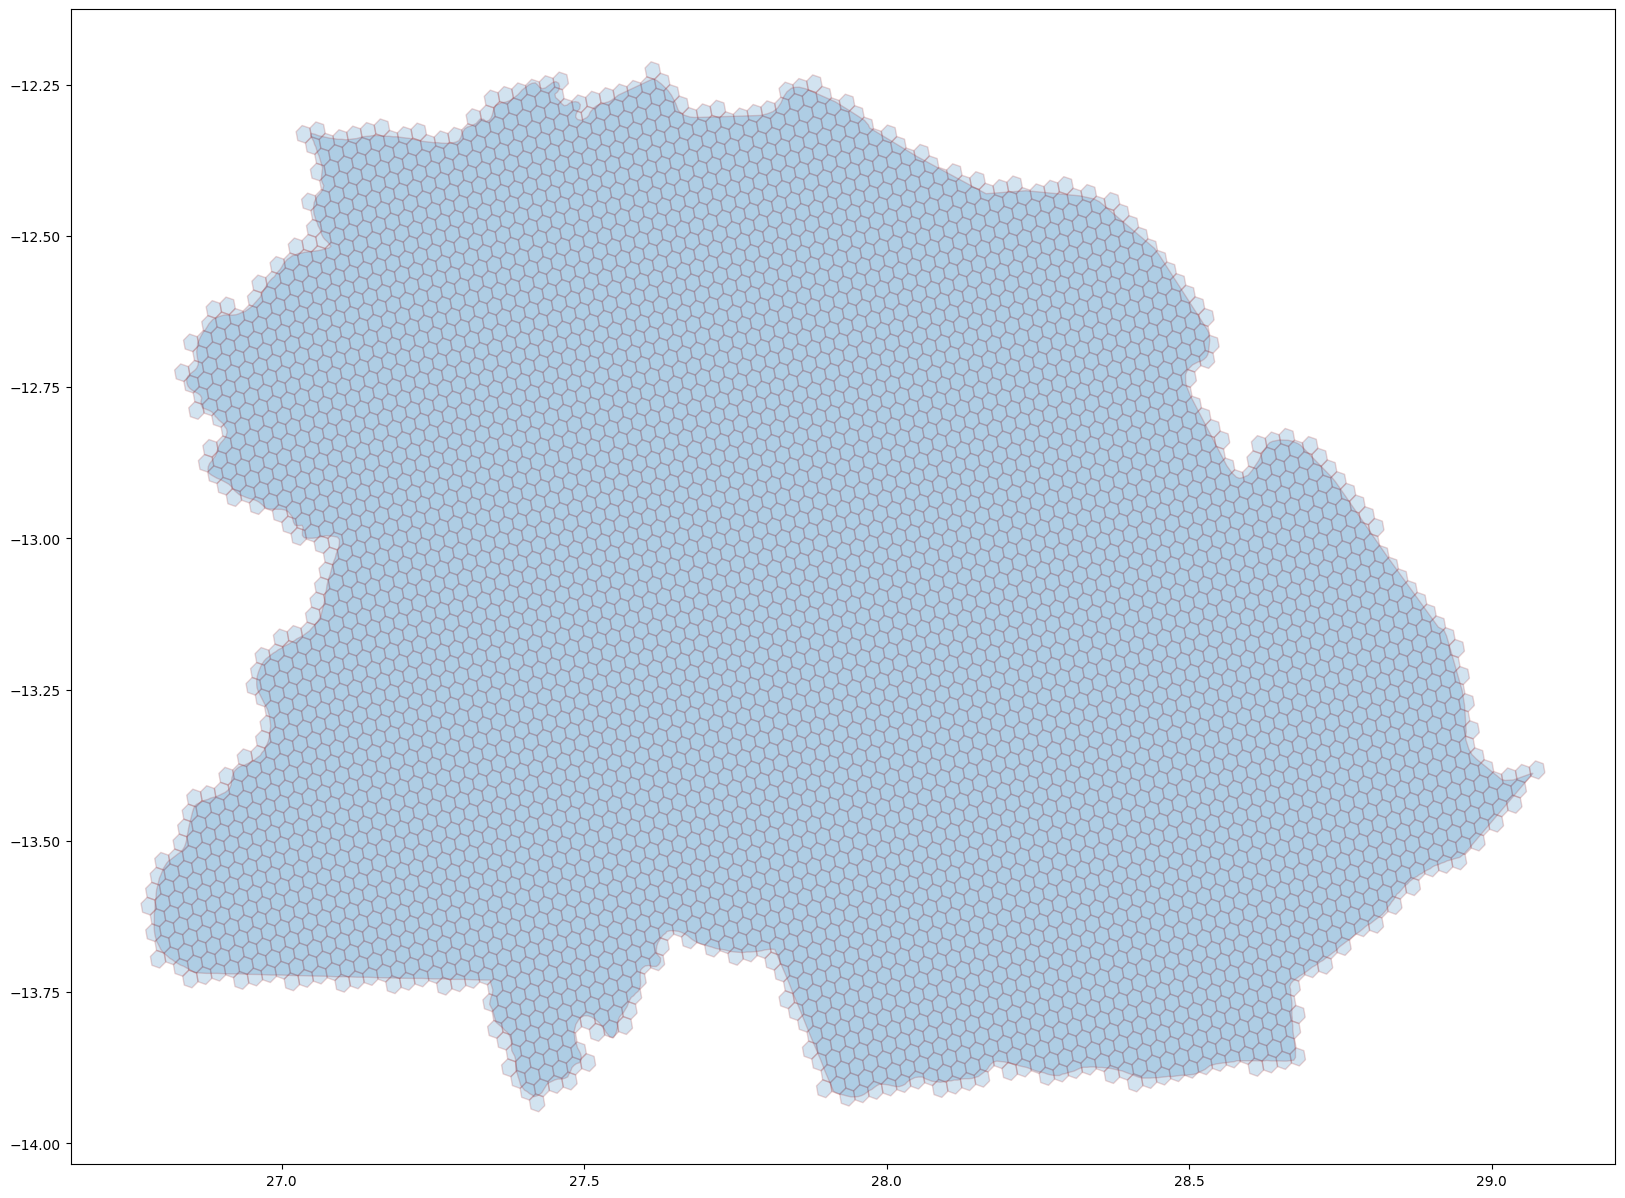

In [7]:
%run BaseGrid.ipynb

In [8]:
# grid = hexagons

# Part 2. Extract GIS-based attributes

## Extract raster values to hexagons

##### Once done with rasters run this cell

In [9]:
# grid = finalizing_rasters(out_path, grid, crs_proj)

Final dataframe

In [10]:
# grid.drop(['index_right'], axis=1, inplace=True)
# grid.head(4)

## Extract information from vector layers

# Part 3. Constructing Multi-vector Demand

### Calculate Total Demand

**Demand = Residential + Commercial + Industrial **

where, 

**Residential** = No of HH with access X average en. cons. kWh/HH/year X wealth adjustment factor

**Commercial**  = (No of buildings X 20 kWh/bld/year) if more than 100 buildings else (No of buildings X 100 kWh/bld/year)

**Industrial**  = Commodity Production (tonnes) from mines X average energy consumption per tonne

['COPPERBELT']
2023-08-22 18:28:05.442342
2023-08-22 18:28:32.095562
2023-08-22 18:28:58.077742
2023-08-22 18:29:18.319680
2023-08-22 18:29:56.012318
2023-08-22 18:30:19.580198
2023-08-22 18:30:21.759564
Electricity consumption : 4,022,500,000 MWh
Electricity consumption : 4,022 TWh


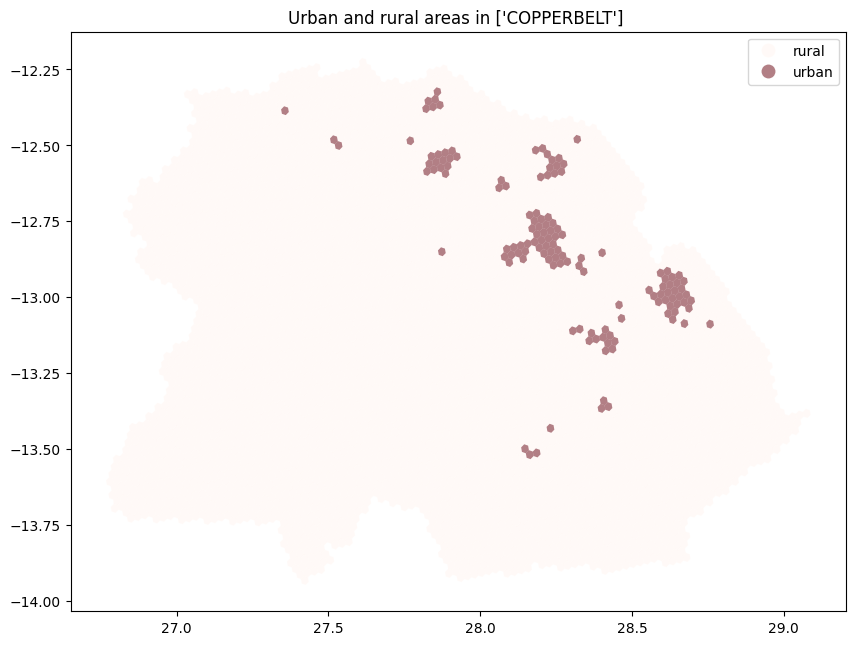

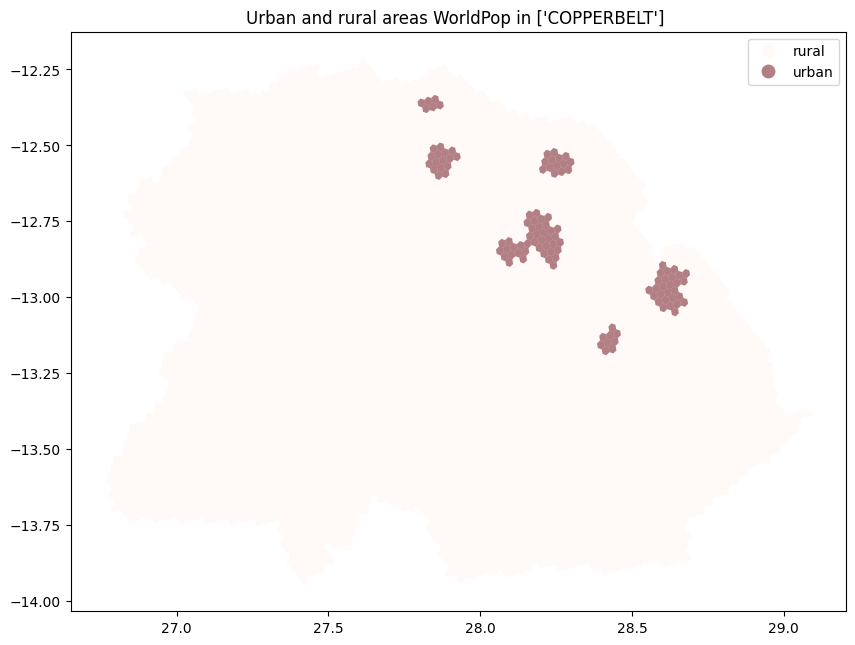

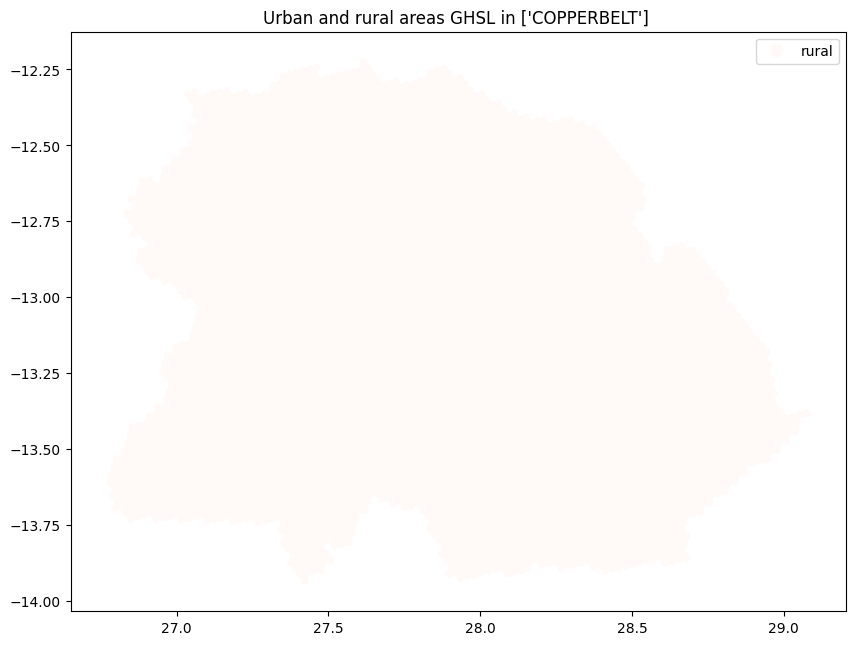

total Buildings: 1,104,219
urban Buildings: 604,165
rural Buildings: 500,054
share Build urban: 55% rural: 45%
nb Of HH per Res Building: urban 1.2 rural 1.0
total Res HH: urban 449,077 rural 85,356
total population: WorldPop 2,888,252 Census 2,513,919
totalResHHWithAccessUrb: 449,039
totalResHHWithAccessRur: 47,808
totalResHHWithAccess: 496,847
0.9296706723208485
0.9319089317168315
-0.2856472189317789
residential electricity consumption: 4,367 GWh


In [11]:
%run Residential/BuildingDemandMethod1.ipynb
total_residentialenergy_assessed = grid["ResEnergy"].sum()
print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh

In [12]:
# grid["Commercial"] = grid.apply(lambda row: (row['buildingscount']*50 if ((row['buildingscount'] > 100))
                                             # else row['buildingscount']*100), axis=1)
# total_servicesenergy_assessed = grid["Commercial"].sum()
# print("services electricity consumption:", f"{total_servicesenergy_assessed/10**6:,.0f}","GWh") # GWh

In [13]:
%run Industry/IndustryDemand.ipynb
print("industry electricity consumption:",f"{total_industryenergy/10**6:,.0f}", "TWh")

total production: 128,215 kt
total industry electricity consumption: 6,360 TWh
energy per tonne of ore: 50 MWh/t
Industry electricity consumption: 1,208 TWh
industry electricity consumption: 1,208 TWh


In [14]:
#Concatenate results
gridRes = gpd.read_file(out_path + "\\" + "res_energy_map.shp")
# gridRes = gridRes.to_crs(crs_proj)
gridInd = gpd.read_file(out_path + "\\" + "ind_energy_map.shp")
# gridInd = gridInd.to_crs(crs_proj)
# init
grid = gridRes.copy()
grid = grid.merge(gridInd, on='id', suffixes=('', '_y'))
# grid = gpd.GeoDataFrame(grid,crs=crs_proj, geometry=grid.geometry)
grid.drop(grid.filter(regex='_y$').columns, axis=1, inplace=True)
# grid = gpd.pd.concat([gridRes, gridInd])
grid.head(4)

hexagons     lon      lat  index_righ   ADM1_NAME  id  buildingss  \
0  875534c4affffff 28.0948 -12.8166      0.0000  COPPERBELT   1    666.0000   
1  873996584ffffff 28.6011 -12.8953      0.0000  COPPERBELT   2    579.0000   
2  875534012ffffff 27.8809 -12.8253      0.0000  COPPERBELT   3     71.0000   
3  8755344f4ffffff 27.8090 -13.2828      0.0000  COPPERBELT   4     13.0000   

     popDens  locationWP  SMOD  ...  ResHHWorld  ResHHWor_1 ResHHNbWit  \
0 1,025.2228      1.0000   NaN  ...    219.5338      0.0000   494.9480   
1 1,096.1873      1.0000   NaN  ...    234.7296      0.0000   430.3713   
2   170.4483      0.0000   NaN  ...      0.0000     33.1611     0.0000   
3    38.5373      0.0000   NaN  ...      0.0000      7.4975     0.0000   

  ResHHNbW_1 ResHHNbW_2 ResEnergyC      ResEnergy  \
0     0.0000   494.9480 4,845.5991 2,397,878.1093   
1     0.0000   430.3713 2,268.4984   976,295.2294   
2     2.2844     2.2844 1,586.3246       683.0667   
3     0.1352     0.1352 2,761.1794        22.7405   

                                            geometry  Ore proces  IndEnergy  
0  POLYGON ((28.10763 -12.82099, 28.09756 -12.831...      0.0000     0.0000  
1  POLYGON ((28.61394 -12.89978, 28.60386 -12.910...      0.0000     0.0000  
2  POLYGON ((27.89371 -12.82973, 27.88364 -12.840...      0.0000     0.0000  
3  POLYGON ((27.82178 -13.28726, 27.81167 -13.297...      0.0000     0.0000  

[4 rows x 29 columns]

In [15]:
# type(gridRes)
# gridRes.column

In [22]:
grid["TotalDem"] = grid.apply(lambda row: (row['ResEnergy']  
                                          # + row['Commercial']  
                                           # +row["IndEnergy"]
                                          ), axis=1)

In [23]:
total = grid.TotalDem.sum()
print("total electricity consumption:", f"{total/10**6:,.0f}","GWh") # GWh

total electricity consumption: 4,367 GWh


In [24]:
grid.head(3)

hexagons     lon      lat  index_righ   ADM1_NAME  id  buildingss  \
0  875534c4affffff 28.0948 -12.8166      0.0000  COPPERBELT   1    666.0000   
1  873996584ffffff 28.6011 -12.8953      0.0000  COPPERBELT   2    579.0000   
2  875534012ffffff 27.8809 -12.8253      0.0000  COPPERBELT   3     71.0000   

     popDens  locationWP  SMOD  ...  ResHHWor_1  ResHHNbWit ResHHNbW_1  \
0 1,025.2228      1.0000   NaN  ...      0.0000    494.9480     0.0000   
1 1,096.1873      1.0000   NaN  ...      0.0000    430.3713     0.0000   
2   170.4483      0.0000   NaN  ...     33.1611      0.0000     2.2844   

  ResHHNbW_2 ResEnergyC      ResEnergy  \
0   494.9480 4,845.5991 2,397,878.1093   
1   430.3713 2,268.4984   976,295.2294   
2     2.2844 1,586.3246       683.0667   

                                            geometry  Ore proces  IndEnergy  \
0  POLYGON ((28.10763 -12.82099, 28.09756 -12.831...      0.0000     0.0000   
1  POLYGON ((28.61394 -12.89978, 28.60386 -12.910...      0.0000     0.0000   
2  POLYGON ((27.89371 -12.82973, 27.88364 -12.840...      0.0000     0.0000   

        TotalDem  
0 2,397,878.1093  
1   976,295.2294  
2       683.0667  

[3 rows x 30 columns]

### Export result

In [25]:
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
grid = grid.to_crs({ 'init': crs_WGS84}) 

In [26]:
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
    grid.to_file(out_path + "\\" + 'total_demand_grid.gpkg', driver="GPKG", index=False, engine='fiona')
#grid.to_file(out_path + "\\" + 'total_demand_grid.geojson', driver="GeoJSON")

## Print maps for quick assessment

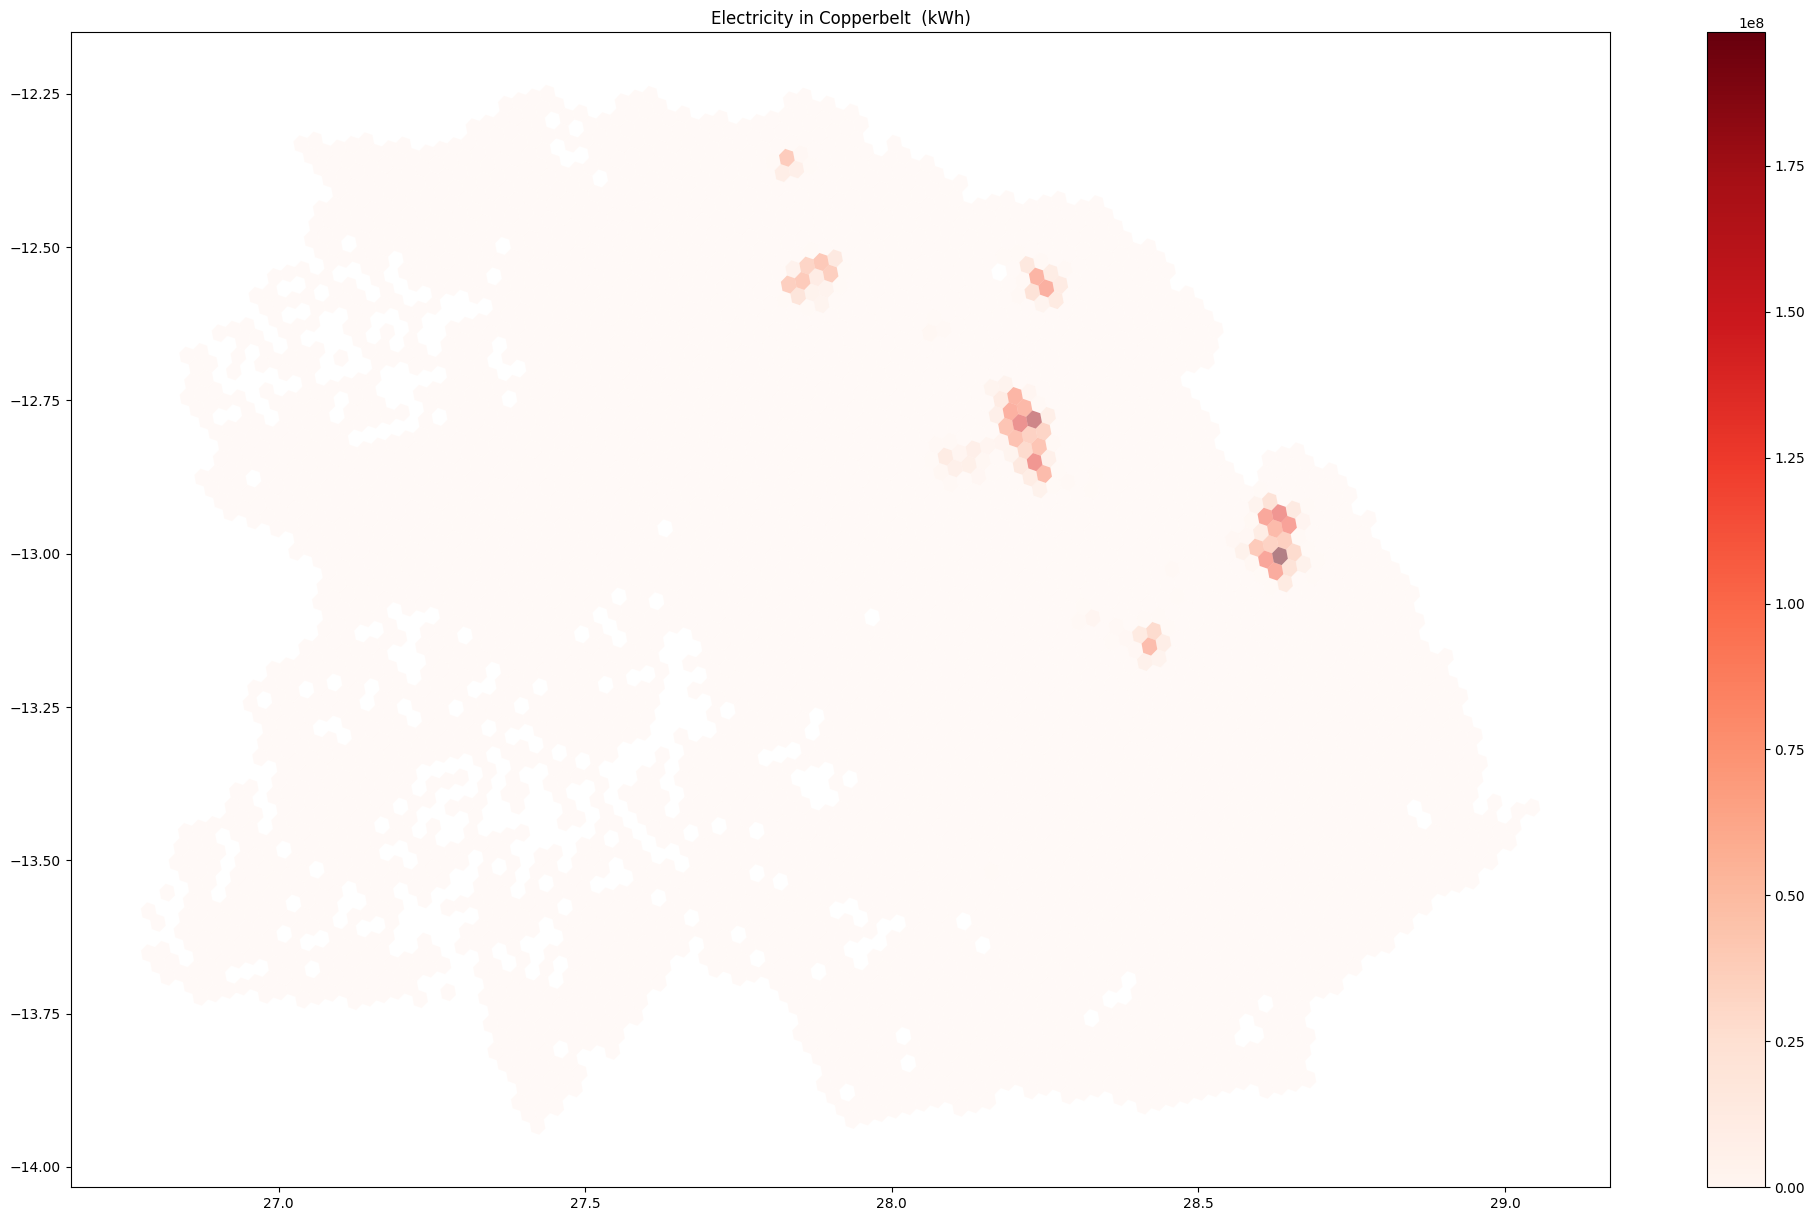

In [28]:
# Plotting for testinf
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot all crops
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity in {} (kWh)'.format("Copperbelt") )

# Save plot as figure 
plt.savefig('sample_priority_map.png', bbox_inches='tight')